In [1]:
%run D:\valkyrie_shared\python\lib\valkyrie\run_notebook_import.py

D:/valkyrie_shared/sim_dir


In [2]:
instrs = stocks_good_dvd()
feature_mgr = FeatureMgr('20210101', '20210630', instrs + ['PFF'], 'sampled_for_ml_ii')
sampled_freq_s = 300
n_sample_per_day = TRADING_SEC_PER_DAY / sampled_freq_s
ret_ns = [round(i * n_sample_per_day) for i in [1] ]

ret_col, s2_col = 'risk_tv', 'cywa_mkt_s2h'
df_tv = feature_mgr.calc_rets_('log', ret_col, ret_ns, s2_col, wmul = 1e-7)
df_tv['parent'] = df_tv['ticker'].apply(parent)

ret_col, s2_col = 'cywa_mkt_xh', 'cywa_mkt_s2h'
df_cy = feature_mgr.calc_rets_('log', ret_col, ret_ns, s2_col, wmul = 1e-7)
df_cy['parent'] = df_cy['ticker'].apply(parent)
gc.collect()

0

In [3]:
ret_ns

[78]

In [4]:
ins_nbs2 = []
for stk in instrs:
    ins_nbs2.append(ml_data.InsNB(stk,   ['PFF']))

In [5]:
xcols = ['cywa_mkt_xh']
ycol = 'risk_tv_ret_78_n'
wcol = 'wgt_cywa_mkt_xh_ret_78_n'
T = 512
mrf = ml_data.MultiRecField(feature_mgr.stk2df, ins_nbs2, xcols, ycol, wcol, T)

In [6]:
dm = ml_data.DataModule.from_dataset(mrf, None, batch_size= 4096)

In [7]:
len(mrf)

324180

In [8]:
n_field, n_instr = 1, 2

class SaotomeNet(ml_modules.Regressor):
    def __init__(self, lr):
        super().__init__('l1')
        self.save_hyperparameters()
        
        c_mul = 2
        n_c0o = n_field
        n_c1o = c_mul * n_c0o
        n_c2o = c_mul * n_c1o
        n_c3o = c_mul * n_c2o
        n_c4o = c_mul * n_c3o
                                        
        self.net = nn.Sequential(
           Filter1D(groups = n_c0o               , n_out_channel = n_c1o, kernel_size = 5, stride = 2),BN1D(n_c1o * n_instr), LReLU(0.01),
           Filter1D(groups = int(n_c1o / n_field), n_out_channel = n_c2o, kernel_size = 3, stride = 2),BN1D(n_c2o * n_instr), LReLU(0.01),
           Filter1D(groups = int(n_c2o / n_field), n_out_channel = n_c3o, kernel_size = 3, stride = 2),BN1D(n_c3o * n_instr), LReLU(0.01),
           Filter1D(groups = int(n_c3o / n_field), n_out_channel = n_c4o, kernel_size = 3, stride = 2),BN1D(n_c4o * n_instr), LReLU(0.01),                       
           nn.LazyConv2d(96, kernel_size=3, stride=1, padding=1), nn.ReLU(),
           nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),                       
           nn.Flatten(),           
           nn.LazyLinear(64), nn.ReLU(),
           nn.LazyLinear(1)
        )
    
class LinearReg(ml_modules.Regressor):
    def __init__(self, lr=1e-3):
        super().__init__('l1')
        self.save_hyperparameters()
                                          
        self.net = nn.Sequential(          
            nn.Flatten(),
            nn.LazyLinear(1))        

In [9]:
net = SaotomeNet(lr = 1e-3)
#net = AlexNet(lr = 1e-3)
X = mrf[0][0]
ml_utils.layer_summary(net, X.shape)
ml_utils.parameter_summary(net)

input shape torch.Size([1, 2, 512])
name : Filter1D output shape:	 torch.Size([1, 2, 2, 256])
name : BN1D output shape:	 torch.Size([1, 2, 2, 256])
name : LeakyReLU output shape:	 torch.Size([1, 2, 2, 256])
name : Filter1D output shape:	 torch.Size([1, 4, 2, 128])
name : BN1D output shape:	 torch.Size([1, 4, 2, 128])
name : LeakyReLU output shape:	 torch.Size([1, 4, 2, 128])
name : Filter1D output shape:	 torch.Size([1, 8, 2, 64])
name : BN1D output shape:	 torch.Size([1, 8, 2, 64])
name : LeakyReLU output shape:	 torch.Size([1, 8, 2, 64])
name : Filter1D output shape:	 torch.Size([1, 16, 2, 32])
name : BN1D output shape:	 torch.Size([1, 16, 2, 32])
name : LeakyReLU output shape:	 torch.Size([1, 16, 2, 32])
name : Conv2d output shape:	 torch.Size([1, 96, 2, 32])
name : ReLU output shape:	 torch.Size([1, 96, 2, 32])
name : Conv2d output shape:	 torch.Size([1, 256, 2, 32])
name : ReLU output shape:	 torch.Size([1, 256, 2, 32])
name : Flatten output shape:	 torch.Size([1, 16384])
name : L

C:\Anaconda3\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


(1284279,
 [10,
  4,
  4,
  12,
  8,
  8,
  24,
  16,
  16,
  48,
  32,
  32,
  13824,
  96,
  221184,
  256,
  1048576,
  64,
  64,
  1])

training finished in : 62.590562 secs


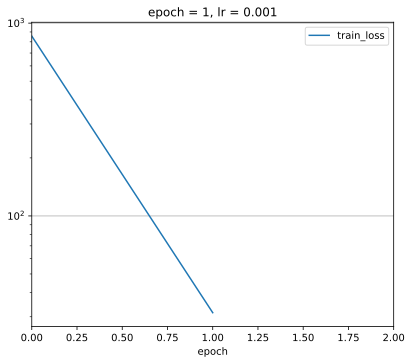

In [10]:
with Timer('training'):    
    trainer = ml_modules.Trainer(max_epochs=2, num_gpus=1)    
    net.apply_init([next(iter(dm.get_dataloader(True)))[0]], ml_utils.init_cnn)
    trainer.fit(net, dm)

In [11]:
with Timer('training'):    
    trainer = ml_modules.Trainer(max_epochs=200, num_gpus=1)    
    net.apply_init([next(iter(dm.get_dataloader(True)))[0]], ml_utils.init_cnn)
    trainer.fit(net, dm)

training finished in : 14.356156 secs


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
trainer.loss_total